<h1>Tarea 01: Diagnosticos en Plasmas - FIM4007 </h1>
Nombre: Marco Ribeiro

Fecha Entrega: 09/05/2024  

<h2>P1)</h2>

El interferograma que analizaremos sera el siguiente:

<p align="center">
  <img src="images/interferometer.png" style=width:800px />
</p>

Primero trataremos de limpiar la imagen, para esto usamos el siguiente codigo para aplicar las siguientes operaciones sobre la imagen en el siguiente orden: la convertimos a escala gris, se aplica un filtro gaussiano, se agudiza, luego se hace una conversión a blanco y negro, y por último un adelgazamiento.

In [130]:
import numpy as np
import cv2, os
import matplotlib.pyplot as plt
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
from skimage.morphology import skeletonize

class InterferometerAnalizer:
    #source:https://stackoverflow.com/questions/45322630/how-to-detect-lines-in-opencv
    def __init__(self, image_path):
        self.og_img = cv2.imread(image_path)
        self.img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        (thresh, img_bw) = cv2.threshold(self.img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        self.img_bw = img_bw

    def process_img(self):
        self.img_to_gray()
        self.gauss_blur_img()
        self.unsharp_mask()
        self.bw_conversion()
        self.thinning()
        self.show_img()

    def save_img(self, saved_file_name):
        cv2.imwrite(saved_file_name, self.img)

    def show_img(self):
        plt.imshow(self.img, cmap='gray')
        plt.show()

    def show_img_bw(self):
        plt.imshow(self.img_bw, cmap='gray')
        plt.show()

    def show_lines(self):
        plt.imshow(self.rot_img, cmap='gray')
        plt.show()
        plt.imshow(self.img_line, cmap='gray')
        plt.show()
        plt.imshow(self.skel_img, cmap='gray')
        plt.show()
    
    def img_to_gray(self):
        gray_img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.img = gray_img
        self.og_img = gray_img

    def gauss_blur_img(self):
        kernel_size = 5
        blur_gray = cv2.GaussianBlur(self.img, (kernel_size, kernel_size), 10)
        self.img = blur_gray

    def unsharp_mask(self):
        alpha, beta, gamma = 1.9, -1.0, 1.0
        unsharp_img = cv2.addWeighted(self.og_img, alpha, self.img, beta, gamma)
        self.img = unsharp_img

    def bw_conversion(self):
        thresh = 200
        img_bw = cv2.threshold(self.img, thresh, 255, cv2.THRESH_BINARY)[1]
        self.img = img_bw

    def thinning(self):
        kernel = np.ones((20,20), np.uint8)
        erosion = cv2.erode(self.img, kernel, iterations=1000)

    def detect_edges(self):
        low_threshold = 50
        high_threshold = 150 
        self.img_edges = cv2.Canny(self.img_bw, low_threshold, high_threshold)

    def get_lines(self):
        rho = 1
        theta = np.pi / 180 
        threshold = 15 
        min_line_len = 3
        max_line_gap = 3
        self.img_line = np.copy(self.img_bw) * 0 
        lines = cv2.HoughLinesP(self.img_edges, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
        for i in lines:
            for x1, y1, x2, y2 in i:
                cv2.line(self.img_line, (x1, y1), (x2, y2), (255, 0, 0), 5)

        self.img_lines_edges = cv2.addWeighted(self.img_bw, 0.8, self.img_line, 1, 0)
        return self.img_line

    def get_skeleton(self):
        skel_img = skeletonize(self.img_bw)
        self.skel_img = skel_img 
        return skel_img 
    
    def rotate_image(self, angle):
        img_cen = tuple(np.array(self.img_bw.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(img_cen, angle, 1.0)
        result = cv2.warpAffine(self.img_bw, rot_mat, self.img_bw.shape[1::-1], flags=cv2.INTER_LINEAR)
        self.rot_img = result
        self.img_bw = result[415:1500,50:1650]
        return result
        

Aplicamos esto sobre la imagen, obteniendo lo siguiente:

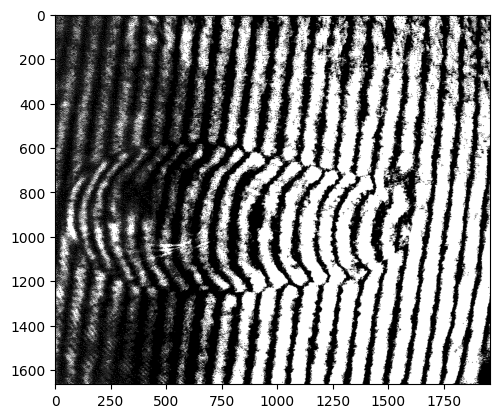

In [2]:
image_path = os.path.join('images', 'interferometer.png')
saved_path = os.path.join('images', 'interferometer_proccessed.png')
a = InterferometerAnalizer(image_path)
a.process_img()
a.save_img(saved_path)



Despues de esto, hacemos correcciones manuales para conectar las lineas discontinuas: 

<p align="center">
  <img src="images/interferometer_manual.png" style=width:800px />
</p>

Con esto tenemos el interferograma con plasma, pero nos falta la imagen de referencia(sin plasma) para poder realizar el calculo de la densidad eléctronica. Para obtener dicha imagen de referencia podemos hacer lo siguiente: primero quitamos la parte de la imagen que contiene el plasma:

<p align="center">
  <img src="images/interferometer_manual_no_plasma.png" style=width:800px />
</p>

Luego, utilizamos un algoritmo de inpainting para hacer una interpolación, llegando asi a una imagen de referencia sin plasma, con este fin, creamos el siguiente codigo:

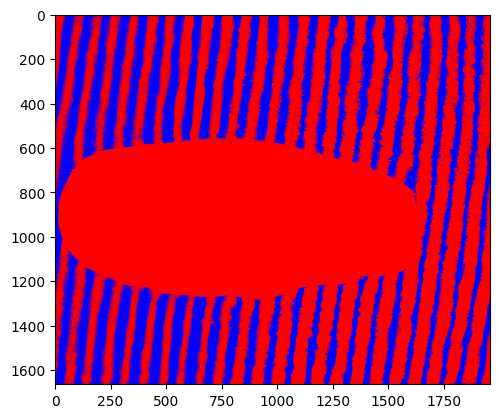

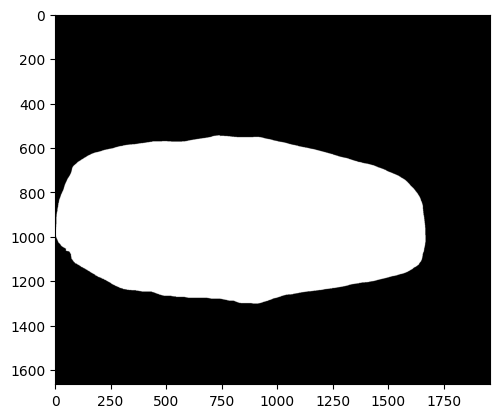

In [3]:
def change_colors(img_file, save_path):
    img = cv2.imread(img_file)
    img[np.where((img==[0,0,0]).all(axis=2))] = [0,0,255]
    img[np.where((img==[255,255,255]).all(axis=2))] = [255,0,0]
    cv2.imwrite(save_path, img)
    plt.imshow(img)
    plt.show()

def make_mask(img_file, save_path):
    img = cv2.imread(img_file)
    height, width = img.shape[0], img.shape[1]
    for i in range(height):
        for j in range(width):
            if img[i, j].sum() > 0:
                img[i, j] = 0
            else:
                img[i, j] = [255, 255, 255]
    cv2.imwrite(save_path, img)
    plt.imshow(img)
    plt.show()
    
img_path = os.path.join('images', 'interferometer_manual_no_plasma.png')
save_path = os.path.join('images', 'int_1.png')
change_colors(img_path, save_path)
img_path = os.path.join('images', 'int_1_defect.png')
save_path = os.path.join('images', 'int_1_mask.png')
make_mask(img_path, save_path)

Ahora que tenemos la mascara necesaria, podemos aplicar el inpainting. Dado que no funciona muy bien este algoritmo, decidimos hacerlo manualmente: 

<p align="center">
  <img src="images/interferometer_manual_no_plasma_1.png" style=width:800px />
</p>

A continuación se puede ver lo que se obtiene con el metodo de inpainting, dado que el plasma ocupa demasiado espacio de la imagen, el algoritmo no logra reconstruir las lineas.

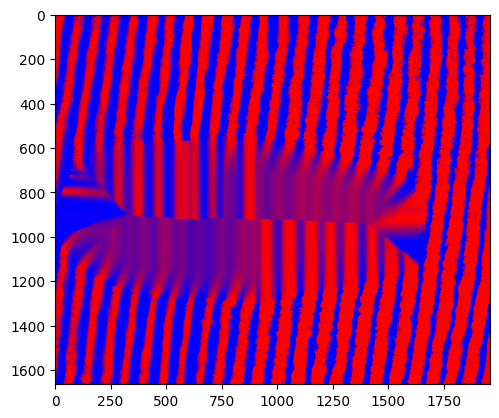

In [4]:
def inpainting(img_file, mask_file, save_path):
    img = cv2.imread(img_file)
    mask = cv2.imread(mask_file, 0)
    dst = cv2.inpaint(img, mask, 10, cv2.INPAINT_NS)    
    cv2.imwrite(save_path, dst)
    plt.imshow(dst)
    plt.show()

img_path = os.path.join('images', 'int_1_defect.png')
mask_path =  os.path.join('images', 'int_1_mask.png')
save_path =  os.path.join('images', 'int_1_inpainted.png')
inpainting(img_path, mask_path, save_path)
    

Como tenemos ambas imagenes, procedemos a realizar la transformada de Fourier de ambas imagenes (FFT) y reconstruimos las imagenes utilizando la transformada inversa. A continuacion se muestra la mascara usada para elegir la frecuencia en el espacio de Fourier, luego el espectro de frecuencias, despues la frecuencia elegida y por último la imagen reconstruida.

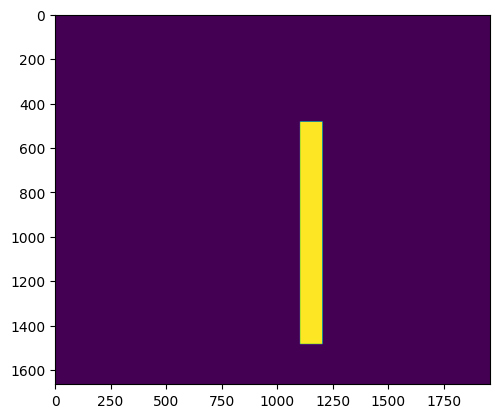

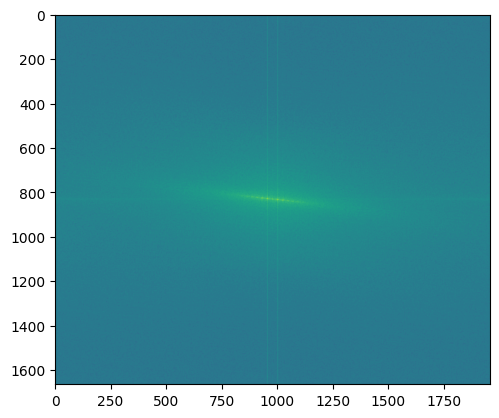

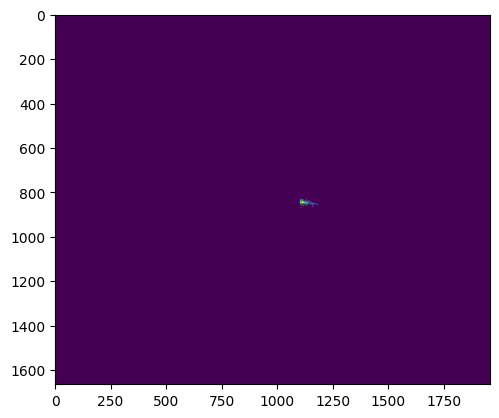

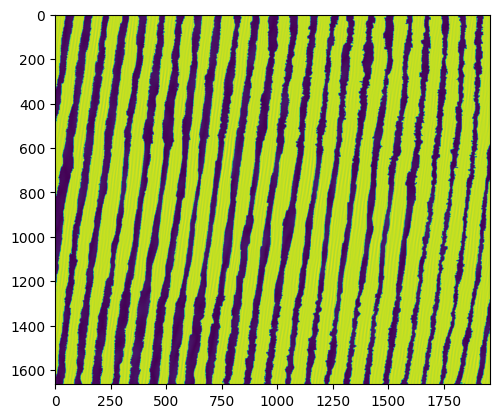

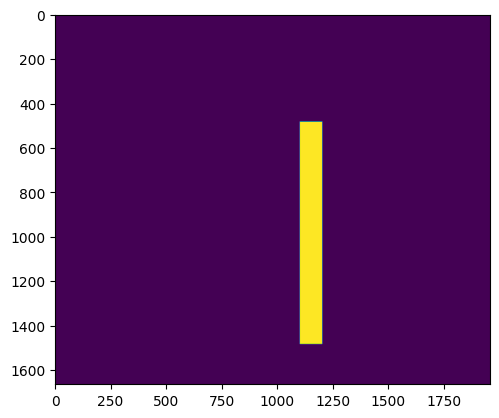

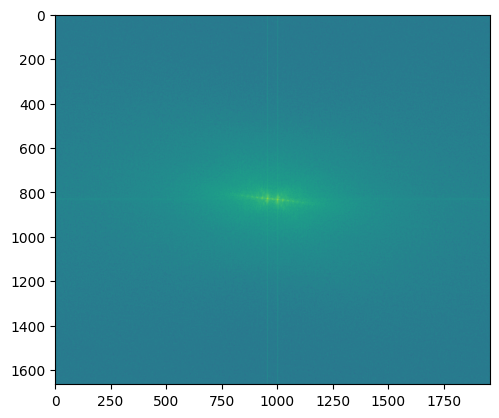

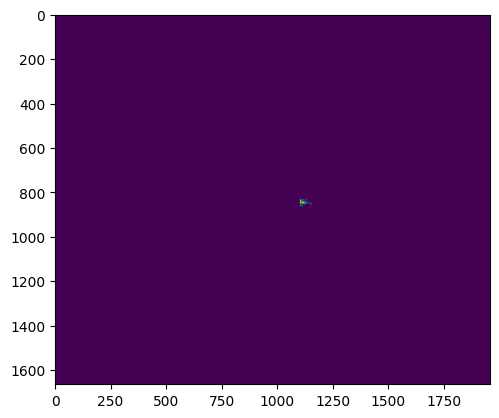

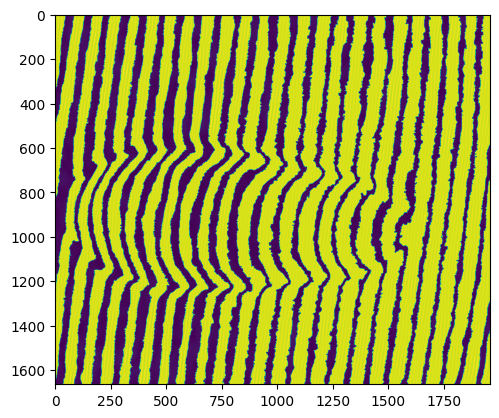

In [5]:
def fourier_transform(img_file, save_path, save_path_mask):
    img = cv2.imread(img_file, 0)
    img_min, img_max = np.amin(img, (0,1)), np.amax(img, (0,1))
    ##
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    #dft = np.fft.fft2(np.float32(img))
    dft_shift = np.fft.fftshift(dft)
    mag, phase = cv2.cartToPolar(dft_shift[:,:,0], dft_shift[:,:,1])
    spec = np.log(mag) / 20 
    ##
    mask = cv2.normalize(spec, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    stencil = np.zeros(mask.shape).astype(mask.dtype)
    freq_points = np.where(mask>=0.85)
    freq_points = np.array(list(zip(freq_points[1], freq_points[0])))
    midpoint = freq_points.shape[0] // 2 
    ##
    first_half = freq_points[:midpoint+1]
    first_mid = first_half.shape[0] // 2
    neg_freq_pos = first_half[first_mid]
    ##
    second_half = freq_points[midpoint:]
    second_mid = second_half.shape[0] // 2 
    pos_freq_pos = second_half[second_mid] + np.array([150, 150])
    ##
    mask = cv2.threshold(mask, 0.65, 1, cv2.THRESH_BINARY)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
    ##
    xcenter = mask.shape[1] // 2
    ycenter = mask.shape[0] // 2
    ##
    square_len = 30
    sq_l = square_len // 2 
    top_left = [pos_freq_pos[0]-sq_l, pos_freq_pos[1]-sq_l*10]
    top_right = [pos_freq_pos[0]+sq_l, pos_freq_pos[1]-sq_l*10]
    bot_left = [pos_freq_pos[0]-sq_l, pos_freq_pos[1]+sq_l*10]
    bot_right = [pos_freq_pos[0]+sq_l, pos_freq_pos[1]+sq_l*10]
    rect_points = np.array([top_left, top_right, bot_right, bot_left])
    contours = [rect_points]
    color = [255,255,255]
    cv2.fillPoly(stencil, contours, color)
    mask = cv2.bitwise_and(mask, stencil)
    #mask = cv2.rectangle(mask, start_point, end_point, color=0, thickness=10) 
    #mask = cv2.circle(mask, (xcenter + 10, ycenter - 5), radius=10, color=0, thickness=cv2.FILLED)
    #mask = cv2.circle(mask, top_left, radius=10, color=0, thickness=cv2.FILLED)
    mag[mask!=0] = 0
    real, imag = cv2.polarToCart(mag, phase)
    back = cv2.merge([real, imag])
    back_ishift = np.fft.ifftshift(back)
    img_back = cv2.idft(back_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])
    mini, maxi = np.amin(img_back, (0,1)), np.amax(img_back, (0,1))
    notched = cv2.normalize(img_back, None, alpha=img_min, beta=img_max, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    ####
    cv2.imwrite(save_path, notched)
    plt.imshow(stencil)
    plt.show()
    plt.imshow(spec)
    plt.show()
    plt.imshow(mask)
    plt.show()
    plt.imshow(notched)
    plt.show()

img_path_ref = os.path.join('images', 'interferometer_manual_no_plasma_1.png')
save_path_ref = os.path.join('images', 'back_fft_ref.png')
save_path_ref_mask = os.path.join('images', 'back_fft_ref_mask.png')
fourier_transform(img_path_ref, save_path_ref, save_path_ref_mask)
img_path_plasma = os.path.join('images', 'interferometer_manual.png')
save_path_plasma = os.path.join('images', 'back_fft_plasma.png')
save_path_plasma_mask = os.path.join('images', 'back_fft_plasma_mask.png')
fourier_transform(img_path_plasma, save_path_plasma, save_path_plasma_mask)
    

A estas imagenes obtenidas por Fourier inverso le aplicamos para el algoritmo de unwrapping modulo $2\pi$ para que las fases esten en el rango $(0, 2\pi)$:

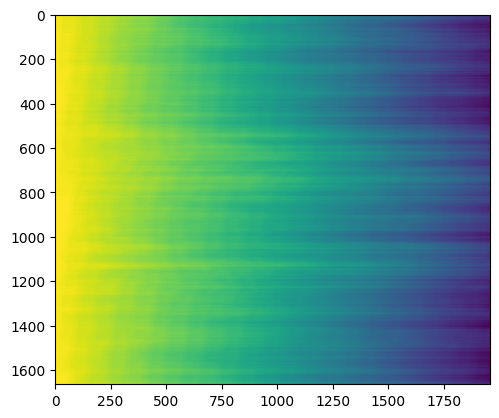

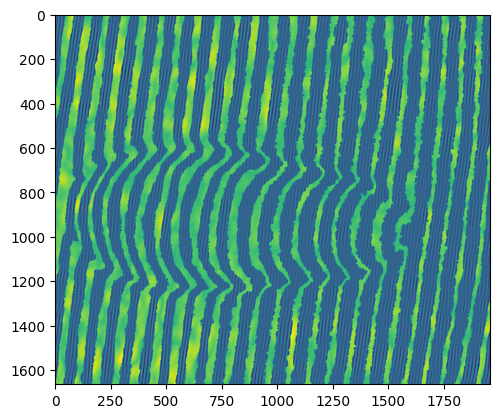

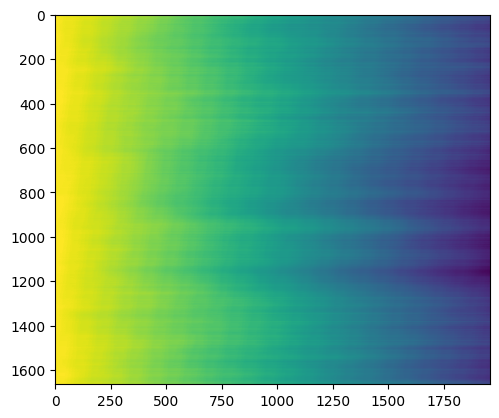

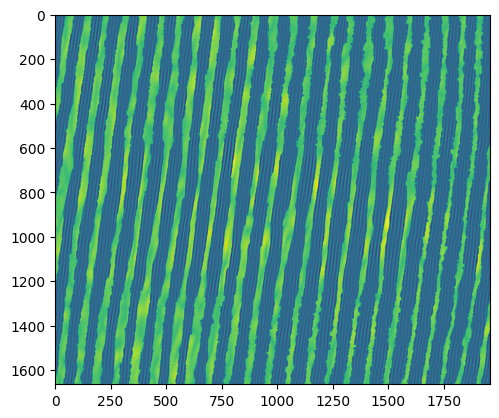

In [6]:
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
def unwrap_img(img_file, save_path):
    
    img = cv2.imread(img_file, 0)
    unwrapped = np.unwrap(img, 3*np.pi/4)
    np.savetxt(save_path, unwrapped)
    plt.imshow(unwrapped)
    plt.show()

def unwrap_img_2(img_file, save_path):
    # Load an image as a floating-point grayscale
    image = cv2.imread(img_file, 0)
    # Scale the image to [0, 4*pi]
    image = exposure.rescale_intensity(image, out_range=(0, 4 * np.pi))
    # Create a phase-wrapped image in the interval [-pi, pi)
    image_wrapped = np.angle(np.exp(1j * image))
    # Perform phase unwrapping
    image_unwrapped = unwrap_phase(image_wrapped, wrap_around=(False, True))
    np.savetxt(save_path, image_unwrapped)
    plt.imshow(image_unwrapped)
    plt.show()

save_path_plasma = os.path.join('images', 'unwrapped_plasma.txt') 
img_path_plasma = os.path.join('images', 'back_fft_plasma.png')
unwrap_img(img_path_plasma, save_path_plasma)
unwrap_img_2(img_path_plasma, save_path_plasma)

save_path_ref = os.path.join('images', 'unwrapped_ref.txt')
img_path_ref = os.path.join('images', 'back_fft_ref.png')
unwrap_img(img_path_ref, save_path_ref)
unwrap_img_2(img_path_ref, save_path_ref)

    

Desafortunadamente al realizar el unwrapping podemos ver que existe efectos tipo "streak", lo que indica presencia de discontinuidades en el mapa de fases.

Entonces, para obtener el mapa de densidades a la imagen (de fases) de referencia le restamos la imagen (de fases) con el plasma:

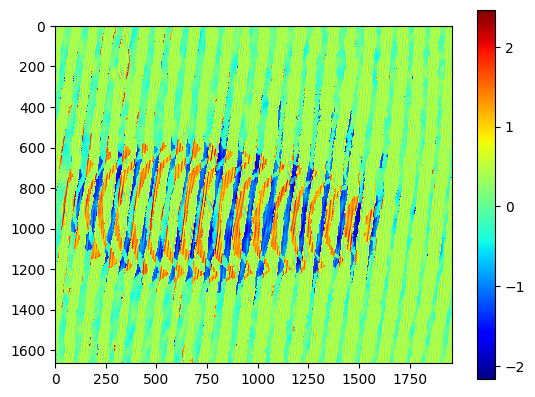

In [7]:
import scipy.constants as sci
def phase_diff(ref_file, plasma_file, save_path):
    
    ref = np.loadtxt(ref_file)
    plasma = np.loadtxt(plasma_file)
    diff = plasma - ref
    c = plt.imshow(diff, cmap="jet", interpolation='nearest')
    cbar = plt.colorbar(c)
    plt.show()

img_path_ref = os.path.join('images', 'unwrapped_ref.txt') 
img_path_plasma = os.path.join('images', 'unwrapped_plasma.txt') 
save_path = os.path.join('images', 'phase_diff.png') 

phase_diff(img_path_ref, img_path_plasma, save_path)

  

Pero como podemos observar, el mapa de densidades de particulas por area no es fisicamente correcto puesto que mezcla deflexiones de lineas de sentido opuesto al interior del plasma. Este error se debe a que el metodo de unwrapping que se esta utilizando encuentra discontinuidades en el mapa de fase y es incapaz de resolver el unwrap. Dado que no funciona realizar el analisis de Fourier, utilizamos el metodo analítico, donde hacemos un ajuste a las lineas interferometricas de referencia y plasma, para calcular el corrimiento entre ellas que indicaria la diferencia de fase de acuerdo a la siguiente ecuación:

$$ \int{n_e dl} = -(\frac{\epsilon_0 m_e}{e^2}) \frac{8 \pi^2 c^2}{\lambda} (\frac{\Delta \phi}{2\pi})$$

Primero rotemos la imagen en 8 grados y recortemosla para hacer el analisis más facil.

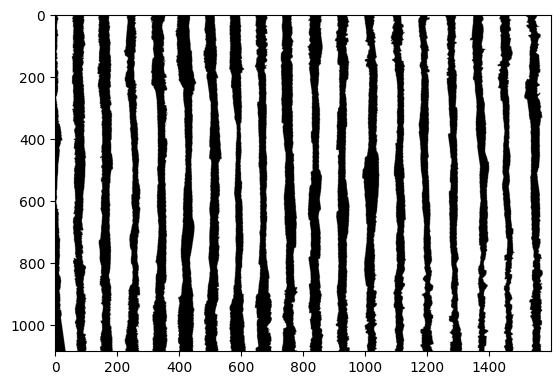

(1085, 1600)


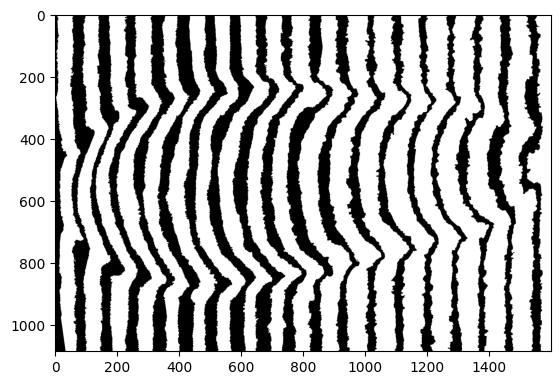

In [166]:
img_path_ref = os.path.join('images', 'interferometer_manual_no_plasma_1.png')
img_path_pla = os.path.join('images', 'interferometer_manual.png')
b = InterferometerAnalizer(img_path_ref)
c = InterferometerAnalizer(img_path_pla)
b.rotate_image(8.0)
b.detect_edges()
lines_ref = b.get_lines()
skel_ref = b.get_skeleton()
img_bw_ref = b.img_bw
b.show_img_bw()
#b.show_lines()
c.rotate_image(8.0)
c.detect_edges()
lines_pla = c.get_lines()
skel_pla = c.get_skeleton()
img_bw_pla = b.img_bw
print(img_bw_pla.shape)
c.show_img_bw()
#c.show_lines()

Ya obtenida la imagen rotada, aplicamos el siguiente algoritmo para detectar las lineas de interferencia y realizar un ajuste polinomial a cada una, para luego calcular la diferencia entre las lineas de referencia y con plasma, lo que nos indicaria el valor $\Delta \phi / 2\pi$.

In [362]:
import plotly.graph_objects as go 

import numpy as np

def split_array_indices(arr):
    num_lines = 19
    # Find indices where zeros occur
    zero_indices = np.where(arr == 0)[0]
    
    # Calculate indices of ones
    all_indices = np.arange(len(arr))
    one_indices = np.setdiff1d(all_indices, zero_indices)
    
    # Split the array using zero indices
    split_indices = []
    start_index = 0
    for end_index in zero_indices:
        current_ones = one_indices[(one_indices >= start_index) & (one_indices < end_index)]
        if len(current_ones) > 0:
            split_indices.append(current_ones)
        start_index = end_index + 1
    
    # Add the last group of ones
    if start_index < len(arr):
        current_ones = one_indices[one_indices >= start_index]
        if len(current_ones) > 0:
            split_indices.append(current_ones)
    
    return split_indices[:19]

def find_avg(img_arr):
    xs_arr = np.array([])
    ys_arr = list()
    div_fact = 1
    for x_ind, row in enumerate(img_arr[::div_fact,]):
        xs_arr = np.append(xs_arr, x_ind * div_fact)
        #lines_arr = np.argwhere(row > 0)
        segmented_lines = split_array_indices(row)
        ys_ind_arr = list()
        for j in segmented_lines:
            avg_y_ind = int(round(np.mean(j)))
            ys_ind_arr.append(avg_y_ind)
        ys_arr.append(ys_ind_arr)
    ys_arr = np.array(ys_arr)
    return xs_arr, ys_arr

def plot_points(xs, ys, poly_deg, ref_or_pla):
    fig = go.Figure()
    for i in range(len(ys[0])):
        ys_ind = ys[:,i]
        z = np.polyfit(xs, ys_ind, poly_deg)
        p = np.poly1d(z)
        fig.add_trace(go.Scatter(x=xs, y=p(xs), mode='lines', name=f"Line Number {i} ({ref_or_pla})"))
        fig.update_layout(
    title={
        'text': f"Polynomial Fit for Interferometry Deflection Lines ({ref_or_pla})",
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title="X Pixel Distance",
    yaxis_title="Y Pixel Distance",
)
    
    fig.show()

avg_xs_pla, avg_ys_pla = find_avg(img_bw_pla)
avg_xs_ref, avg_ys_ref = find_avg(img_bw_ref)
plot_points(avg_xs_ref, avg_ys_ref, 1, 'Reference')
plot_points(avg_xs_pla, avg_ys_pla, 6, 'Plasma')

<p align="center">
  <img src="graphs/plasma_line.png" style=width:800px />
</p>

<p align="center">
  <img src="graphs/reference_line.png" style=width:800px />
</p>

Mostramos una de las 19 curvas calculadas, para las lineas de referencia el ajuste es a un polinomio de grado 1 y para las de interferometria a uno de grado 6.

Para obtener la densidad de linea eléctronica podemos usar la siguiente aproximación, considerando que estamos usando un láser con longitud de $\lambda = 532[nm]$:

$$ \int{n_e dl} \approx -4.19 \times 10^{21} (\frac{\Delta \phi}{2 \pi}) [m^{-2}]$$

Asi que calculando la diferencia entre ambos ajustes (donde valores positivos indicaran presencia de electrones y negativos neutros, de acuerdo a lo que se observa en la dirección de deflexión de las franjas de interferencia):

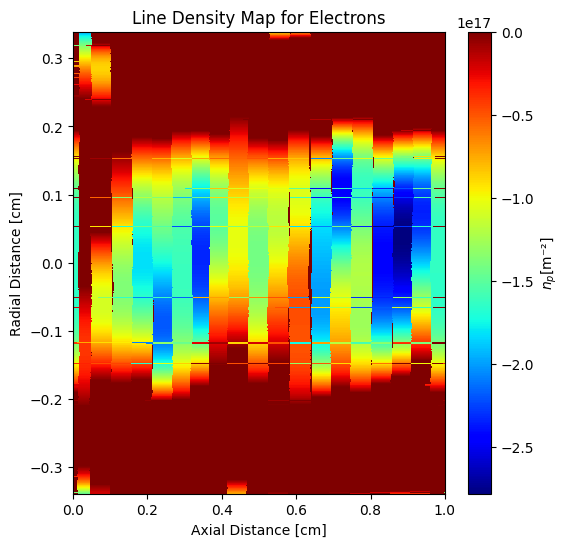

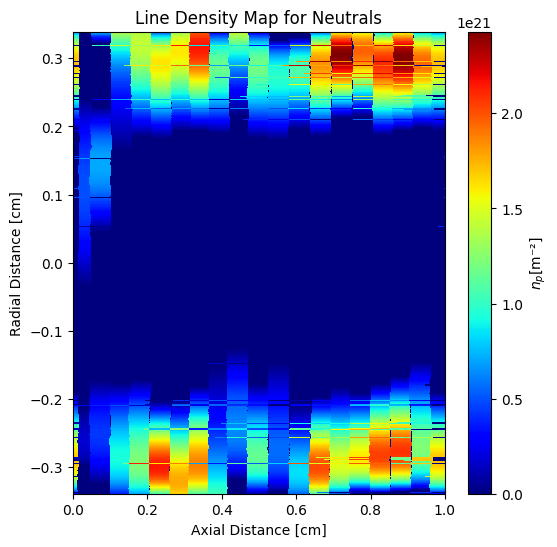

In [373]:
def plot_density(xs_ref, ys_ref, xs_pla, ys_pla, poly_deg_ref, poly_deg_pla, neutral):
    pic = np.zeros((1085, 1600))
    pix_to_m = (1 * 10 ** -2) / 1600 #1cm = 1600 pix
    electron_factor = -4.19 * 10 ** 21  #m⁻²
    neutral_factor = 2.68 * 10 ** 25
    fig = go.Figure()
    xs_ref_m = xs_ref * pix_to_m
    xs_pla_m = xs_pla * pix_to_m
    phases_list = list()
    for i in range(len(ys_ref[0])):
        ys_ind_ref_m = ys_ref[:,i] * pix_to_m
        ys_ind_pla_m = ys_pla[:,i] * pix_to_m
        z_ref = np.polyfit(xs_ref_m, ys_ind_ref_m, poly_deg_ref)
        z_pla = np.polyfit(xs_pla_m, ys_ind_pla_m, poly_deg_pla)
        p_ref = np.poly1d(z_ref)
        p_pla = np.poly1d(z_pla)
        p_diff = p_pla - p_ref #delta phi / 2 pi
        phases_list.append(p_diff)

    xs_ref = np.array([int(i) for i in xs_ref])
    for ind, poly in enumerate(phases_list):
        values = poly(xs_ref_m)
        posi_val = values > 0
        nega_val = values < 0
        if neutral:
            values[nega_val] *= -neutral_factor
        else:
            values[posi_val] *= electron_factor

        for j in range(45):
            pic[xs_ref, (ys_ref[:,ind] + j) % 1600] = values  
            pic[xs_ref, (ys_ref[:,ind] - j) % 1600] = values  
    
    x, y = np.linspace(0, pic.shape[1], pic.shape[1] + 1) * pix_to_m * 100 \
        , np.linspace(-pic.shape[0] / 2, pic.shape[0] / 2, pic.shape[0] + 1) * pix_to_m * 100
    fig, ax = plt.subplots(1, figsize=(6,6))
    plt.xlabel("Axial Distance [cm]")
    plt.ylabel("Radial Distance [cm]")
    if neutral:
        ax.set_title('Line Density Map for Neutrals')
    else:
        ax.set_title('Line Density Map for Electrons')

    c = plt.imshow(pic, extent=[x.min(), x.max(), y.min(), y.max()],cmap="jet", interpolation='nearest',origin='lower', aspect='auto')
    cbar = plt.colorbar(c)
    cbar.set_label("$n_p$[m⁻²]")
    plt.show()

plot_density(avg_xs_ref, avg_ys_ref, avg_xs_pla, avg_ys_pla, 1, 6, False)
plot_density(avg_xs_ref, avg_ys_ref, avg_xs_pla, avg_ys_pla, 1, 6, True)

Geometricamente la distribución de densidad no parece ser la correcta, pero los valores para la densidad electrónica ($\approx 10^{17} m^{-2}$) son razonables para el plasma que se esta estudiando (en aire a presion atmosférica) y además se puede distinguir la zona de neutros y electrones cualitativamente.

<h2>P2)</h2>

Queremos generar un plasma con densidad eléctronica usando una distribución Gaussiana como:

$$ n_e(r) = n_0 e^{-(r-\mu)^2/(2\sigma^2)} $$

Donde elegimos $n_0 = 5 \times 10^{24} m^{-3}$ para que este sea el valor máximo como dice el enunciado y luego determinamos $\sigma$ y $\mu$ para el item (a) y (b):

Para (a), $\mu_a = 0$ y $\sigma_a$ estara dado por:

$$ n_e(3) = 10^{22} m^{-3} = 5 \times 10^{24} e^{-3^2/(2\sigma_a^2)} [m^{-3}] $$

Despejando $\sigma_a$:

$$ \sigma_a = \sqrt{\frac{9}{2ln(500)}} \approx 0.85 $$

Asi que la función sera:

$$ \boxed{n_e(r) = 5 \times 10^{24} e^{-r^2/(2\times 0.85^2)}} $$

Mientras que para (b), $\mu_b = 5$ y $\sigma_b$:

$$ n_e(0) = 10^{22} m^{-3} = 5 \times 10^{24} e^{-5^2/2\sigma_b^2} [m^{-3}] $$

Luego $\sigma_b$ es:

$$ \sigma_b = \sqrt{\frac{25}{2ln(500)}} \approx 1.42$$

Y la función:

$$ \boxed{n_e(r) = 5 \times 10^{24} e^{-(r-5)^2/(2\times 1.42^2)}} $$

Usamos el siguiente codigo para definir nuestra función gaussiana:

In [341]:
import numpy as np

def gaussian_func(r, A, mu, sigma):
    return A * np.exp(-(r - mu) ** 2 / (2 * sigma ** 2))

A = 5 * 10 ** 24 
mu_a, sigma_a = 0, np.sqrt(9 / (2 * np.log(500)))
mu_b, sigma_b = 5, np.sqrt(25 / (2 * np.log(500)))

Para la imagen del interferograma, podemos calcular cuanto se desplaza la linea de acuerdo a la ecuación: 

$$ 0.24 \times 10^{-21} \int{n_e(r) dl} \approx (\frac{\Delta \phi}{2 \pi}) = y(r)$$

Reemplaando la expresión para la parte (a):

$$y(r) = 0.24 \times 10^{-21} · 5 \times 10^{24} \int{ e^{-r^2/(2\times 0.85^2)} dl}$$

Asumiendo que el plasma es de una longitud $\sim 6 [mm]$ para (a) y $\sim 10 [mm]$ para (b):

$$y(r) \approx 1.2 \times 10^{3} · 6 \times 10^{-3} e^{-r^2/(2\times 0.85^2)} = 7.2 e^{-r^2/(2\times 0.85^2)} $$

Por otro lado para (b):

$$y(r) = 0.24 \times 10^{-21} · 5 \times 10^{24} \int{ e^{-(r-5)^2/(2\times 1.42^2)} dl}$$

Y considerando la longitud del plasma mencionada anteriormente para (b):

$$y(r) \approx 1.2 \times 10^{3} · 10 \times 10^{-3} e^{-r^2/(2\times 0.85^2)} = 12 e^{-(r-5)^2/(2\times 1.42^2)} $$

Entonces, usando una imagen de 2000x2000 pixeles, donde tomamos que 20[mm] equivale a 2000 pixeles.

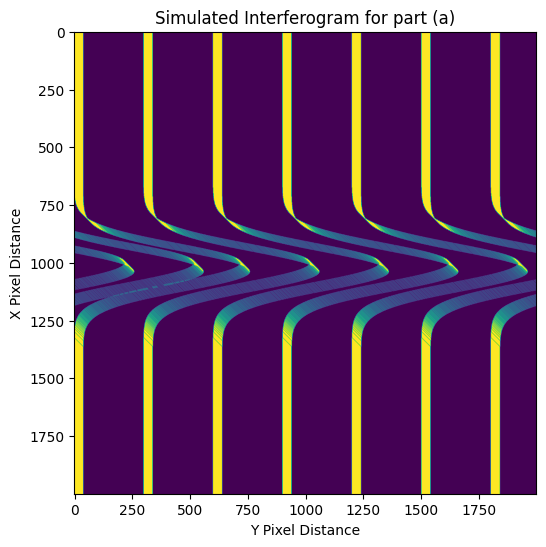

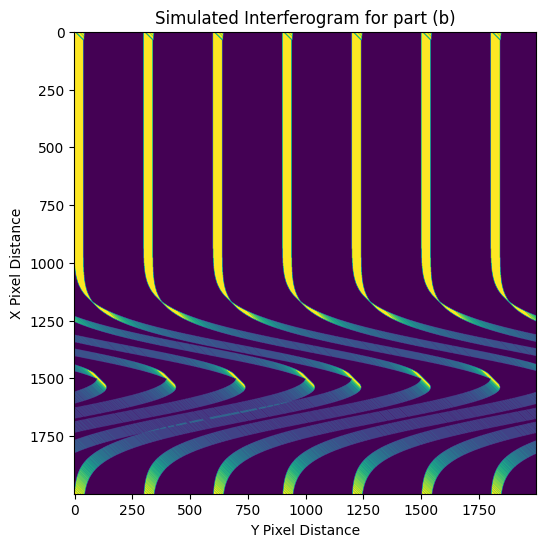

In [393]:
def plot_interferogram(A, mu, sigma, name, L):
    img_size = 2000
    rs = np.linspace(-10, 10, img_size)
    ys = 0.24 * 10 ** -21 * L * 10 ** -3 * gaussian_func(rs, A, mu, sigma)
    pix_to_m = 20 / img_size 
    ys_pix = (ys / pix_to_m)
    ys_pix = np.array([round(i) for i in ys_pix])
    pic = np.zeros((img_size, img_size))
    xs_pix = np.arange(pic.shape[0])
    for i in xs_pix[::300]:
        for j in range(40):
            pic[(xs_pix + j) % img_size, (ys_pix + i + j) % img_size] = 1
    
    fig, ax = plt.subplots(1, figsize=(6,6))
    plt.xlabel("Y Pixel Distance")
    plt.ylabel("X Pixel Distance")
    ax.set_title(f'Simulated Interferogram for part {name}')
    plt.imshow(pic)
    plt.show()

part_a_gauss = {"A": 5 * 10 ** 24, "mu": mu_a, "sigma":sigma_a, "name": "(a)", "L":6}
part_b_gauss = {"A": 5 * 10 ** 24, "mu": mu_b, "sigma":sigma_b, "name": "(b)", "L":10}
plot_interferogram(**part_a_gauss)
plot_interferogram(**part_b_gauss)

Obtenemos las franjas de interferencia de ambas configuraciones de densidad eléctronica.

Para la imagen de Schlieren, supongamos que tenemos un knife edge puesto de tal manera que lo que se observa en el detector es el gradiente en la dirección $x$ (de arriba hacia abajo en las figuras que hemos presentado), entonces, de acuerdo a la definición de la deflexión angular ocasionada por dicho gradiente, tendriamos:

$$\theta_x = (\frac{e^2}{8 \pi^2 \epsilon_0} \frac{1}{m c^2}) \lambda^2 \int_A^B{\frac{\partial n_e}{\partial x}} $$

Entonces, haciendo los mismos supuestos de antes, con $\lambda = 532 [nm]$, y considerando la integral como una simple multiplicación por la longitud del plasma (6[mm]) tendremos que:

$$ \theta_x \approx 1.27 \times 10^{-28} · 6 \times 10^{-3} \frac{\partial n_e}{\partial x}  $$ 

Luego, podemos calcular la derivada en la dirección $x$ de la densidad Gaussiana programaticamente utilizando el metodo de diferencias finitas:

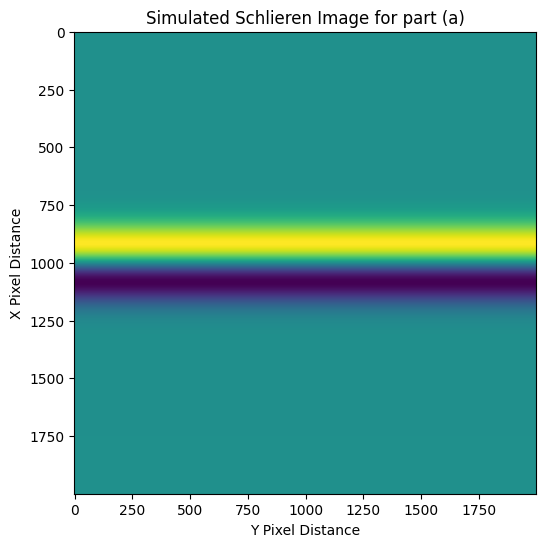

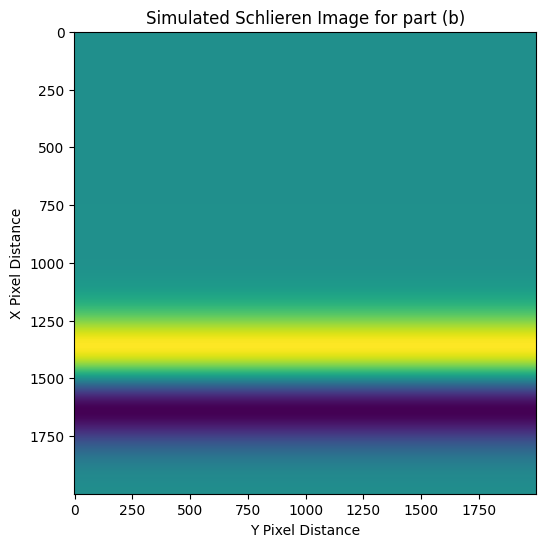

In [394]:
def derive_densities(A, mu, sigma, name, L):
    img_size = 2000
    rs = np.linspace(-10, 10, img_size)
    ne = gaussian_func(rs, A, mu, sigma)
    pix_to_m = 20 / img_size 
    pic = np.zeros((img_size, img_size))
    xs_pix = np.arange(pic.shape[0])
    for i in xs_pix:
        pic[:,i] = ne
    dx_matrix = np.diff(pic, axis=0, prepend=0)
    theta_x = dx_matrix * 1.27 * 10 ** -28 * L * 10 ** -3
    fig, ax = plt.subplots(1, figsize=(6,6))
    plt.xlabel("Y Pixel Distance")
    plt.ylabel("X Pixel Distance")
    ax.set_title(f'Simulated Schlieren Image for part {name}')
    plt.imshow(theta_x)
    plt.show()
    return

derive_densities(**part_a_gauss)
derive_densities(**part_b_gauss)


Como la derivada se calcula de arriba hacia abajo, la parte más clara (más amarilla en la imagen) indica mayor cambio de densidad ya que la pendiente de la Gaussiana sube por ese tramo, mientras que la oscura evidencia la bajada de la Gaussiana. 

Por último para las rotaciones de Faraday, sabemos que el cambio del ángulo de polarización sera proporcional a la intensidad medida por el detector, por ende, queremos calcular esta diferencia de ángulos dada por:

$$ \Delta \phi = \frac{e^2 \lambda^2}{8 \pi^2 c^3 m_e^2 \epsilon_0} \int_A^B{n_e \vec{B} \cdot \vec{dl}} $$

Lo que sera aproximadamente igual a (usando $\lambda = 532[nm]$):

$$ \Delta \phi \approx 2.63 \times 10^{-13} \lambda^2 \int_A^B{n_e \vec{B} \cdot \vec{dl}} = 7.44 \times 10^{-26} \int_A^B{n_e \vec{B} \cdot \vec{dl}} $$ 

También necesitamos saber como es el campo magnético del plasma, pero como nos dicen por enunciado que la corriente que circula por este es axial, es posible estimar la magnitud del campo azimutal que comprime al plasma por la ley de Ampere:

$$ |\vec{B}| = \frac{\mu_0 I}{2 \pi R} $$

Nos dan que la corriente es de $I=400[kA]$, asi para (a) y (b) tendremos ($R_a = 3[mm]$ y $R_b = 5[mm]$):

$$ |\vec{B_a}| \approx 27.7 [T] $$
$$ |\vec{B}_b| \approx 16.0 [T] $$

Ademas, si asumimos que $n_e$ no cambia mucho en el camino $dl$:

$$  \Delta \phi \approx 7.44 \times 10^{-26} · L n_e |\vec{B}| \cos{\theta} $$

Donde $\theta$ dependera de $r$ asi que:

$$  \Delta \phi \approx 7.44 \times 10^{-26} · L |\vec{B}| n_e(r) \cos{\theta(r)} $$

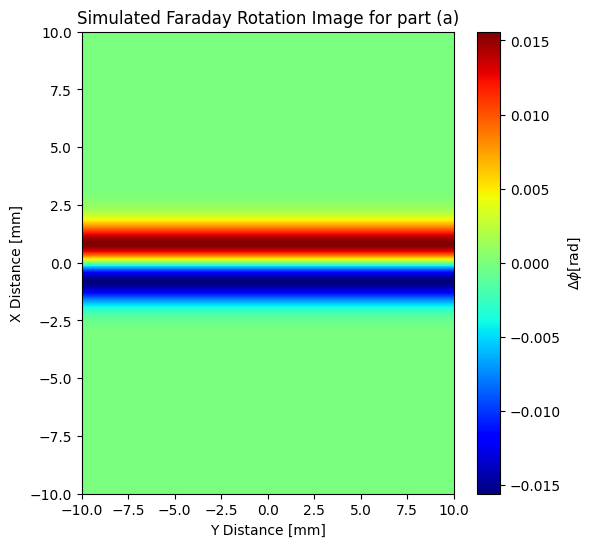

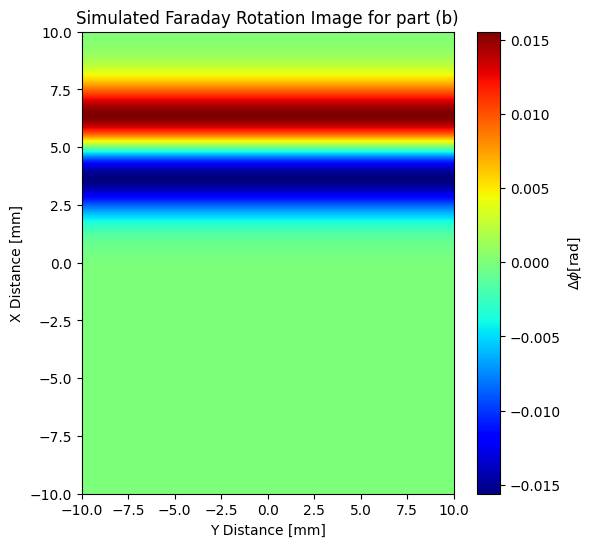

In [460]:
import scipy.constants as sci 
import copy

def faraday_rotation(A, mu, sigma, name, L):
    I_current = 400 * 10 ** 3
    B_mag = sci.mu_0 * I_current / (2 * sci.pi * (L / 2))
    img_size = 2000
    rs = np.linspace(-10, 10, img_size)
    ne = gaussian_func(rs, A, mu, sigma)
    pix_to_m = 20 / img_size 
    pic = np.zeros((img_size, img_size))
    xs_pix = np.arange(pic.shape[0])
    cond = abs(rs - mu) > (L/2)
    cond2 = abs(rs - mu) <= (L/2)
    a = copy.deepcopy(rs)
    a[cond] = 0
    P = len(a[cond2])
    theta = np.linspace(np.pi, 0, P)
    cos = np.cos(theta)
    a[cond2] = cos 
    for i in xs_pix:
        angle = ne[i] * 7.44 * 10 ** -26 * L * B_mag * a[i]
        pic[i,:] = angle
    
    fig, ax = plt.subplots(1, figsize=(6,6))
    plt.xlabel("Y Distance [mm]")
    plt.ylabel("X Distance [mm]")
    ax.set_title(f'Simulated Faraday Rotation Image for part {name}')
    c = plt.imshow(pic, extent=[rs.min(), rs.max(), rs.min(), rs.max()],cmap="jet", interpolation='nearest',origin='lower', aspect='auto')
    cbar = plt.colorbar(c)
    cbar.set_label("$\Delta \phi$[rad]")
    plt.show()
    return

faraday_rotation(**part_a_gauss)
faraday_rotation(**part_b_gauss)

Como podemos ver en las figuras, se ven bastantes similares a las de schilieren, esto se debe a como se determino el ángulo relativo entre el campo magnético y la dirección de integración, donde se considera que $\theta$ aumenta linealmente con $r$ en la región dentro del plasma (dentro de una desviación estandar $\sigma$). Aqui ademas se considero que la corriente fluye hacia la derecha, por ende el campo sale del plano de la pantalla por la parte superior (rojo) del plasma y entre a la pantalla por la parte inferior(azul), lo que justifica los valores positivos y negativos de $\Delta \phi$